# Early Fusion Model for Skin Cancer detection

In [1]:
import os
import io
import time
import copy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import h5py
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight
from torch.utils.data import DataLoader, Dataset, random_split
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import models, transforms

### Dataset

In [2]:
PATH = 'dataset'
train_metadata_path = os.path.join(PATH, 'train-metadata.csv')

# Load data
train_metadata_unprocessed = pd.read_csv(train_metadata_path, low_memory=False)

# Columns to drop (excluding isic_id for now, we'll keep it until after splits)
to_drop_columns = ['patient_id', 'image_type', 'attribution', 'copyright_license', 'lesion_id']
train_only_columns = ['iddx_full', 'iddx_1', 'iddx_2','iddx_3', 'iddx_4', 'iddx_5', 
                      'mel_mitotic_index', 'mel_thick_mm', 'tbp_lv_dnn_lesion_confidence']
one_hot_columns = ['age_approx','sex', 'anatom_site_general', 'tbp_tile_type','tbp_lv_location', 'tbp_lv_location_simple']
numerical_columns = ['clin_size_long_diam_mm', 'tbp_lv_A', 'tbp_lv_Aext', 'tbp_lv_B', 'tbp_lv_Bext',
                     'tbp_lv_C', 'tbp_lv_Cext', 'tbp_lv_H', 'tbp_lv_Hext', 'tbp_lv_L', 'tbp_lv_Lext',
                     'tbp_lv_areaMM2', 'tbp_lv_area_perim_ratio', 'tbp_lv_color_std_mean', 'tbp_lv_deltaA',
                     'tbp_lv_deltaB', 'tbp_lv_deltaL', 'tbp_lv_deltaLB', 'tbp_lv_deltaLBnorm', 'tbp_lv_eccentricity',
                     'tbp_lv_minorAxisMM', 'tbp_lv_nevi_confidence', 'tbp_lv_norm_border', 'tbp_lv_norm_color',
                     'tbp_lv_perimeterMM', 'tbp_lv_radial_color_std_max', 'tbp_lv_stdL', 'tbp_lv_stdLExt',
                     'tbp_lv_symm_2axis', 'tbp_lv_symm_2axis_angle', 'tbp_lv_x', 'tbp_lv_y', 'tbp_lv_z']

In [3]:
# Downsample to fix class imbalance in the target, to have a similar number of instances for two classes.
positives = train_metadata_unprocessed[train_metadata_unprocessed['target'] == 1]
negatives = train_metadata_unprocessed[train_metadata_unprocessed['target'] == 0]
n_samples = positives.shape[0]
sampled_negatives = negatives.sample(n=n_samples, random_state=42)
train_metadata = pd.concat([sampled_negatives, positives])

# Drop irrelevant columns (but keep isic_id for alignment)
train_metadata = train_metadata.drop(columns=to_drop_columns, errors='ignore')

# Drop train-only columns
train_metadata = train_metadata.drop(columns=train_only_columns, errors='ignore')

We encoded the data to make it suitable for the training. Different type of data are handled differently:

Low cardinality categorical features: one-hot encoding
Numerical data: standardization

In [4]:
# One-hot encoding
train_one_hot = [c for c in train_metadata.columns if c in one_hot_columns]
train_metadata = pd.get_dummies(train_metadata, columns=train_one_hot)
scaler = StandardScaler()

# standardizing numerical features
for c in numerical_columns:
    if c in train_metadata.columns:
        train_metadata[c] = scaler.fit_transform(train_metadata[[c]])
X_full = train_metadata.drop(columns=['target'], errors='ignore')
y_full = train_metadata['target']
print("X_full shape:", X_full.shape)  # should be (393, number_of_features)
print("y_full value counts:\n", y_full.value_counts())

X_full shape: (786, 84)
y_full value counts:
 target
0    393
1    393
Name: count, dtype: int64


In [5]:
# Compute correlation without 'isic_id'
numeric_df = train_metadata.drop(columns=['isic_id'], errors='ignore')

correlation_matrix = numeric_df.corr()
target_correlation = correlation_matrix['target'].abs().sort_values(ascending=False)
# Feature importance using random forest
X_for_rf = X_full.drop(columns=['isic_id'], errors='ignore')  # Don't use isic_id in RF
rf_model = RandomForestClassifier(random_state=26)
rf_model.fit(X_for_rf, y_full)
feature_importances = pd.Series(rf_model.feature_importances_, index=X_for_rf.columns).sort_values(ascending=False)

# Select top features
correlated_features = target_correlation[target_correlation >= 0.05].index.drop('target')
rf_features = feature_importances.head(15).index
top_features = correlated_features.union(rf_features)
top_features_list = list(top_features)
if 'isic_id' not in top_features_list:
    top_features_list.append('isic_id')
X_temp, X_test, y_temp, y_test = train_test_split(
    X_full, y_full, 
    test_size=0.1,  # 10% test first
    stratify=y_full, 
    random_state=42
)
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp,
    test_size=0.111111, # approx 10% of original dataset, given we already split out 10%
    stratify=y_temp,
    random_state=42
)
print("Train size:", len(X_train))
print("Val size:", len(X_val))
print("Test size:", len(X_test))

Train size: 628
Val size: 79
Test size: 79


Splitting the dataset

In [6]:
# creating validation, test and training set
X_train = X_train[top_features_list].copy()
X_val = X_val[top_features_list].copy()
X_test = X_test[top_features_list].copy()
train_isic_ids = X_train['isic_id'].astype(str)
val_isic_ids = X_val['isic_id'].astype(str)
test_isic_ids = X_test['isic_id'].astype(str)
# Drop isic_id column
X_train = X_train.drop('isic_id', axis=1, errors='ignore')
X_val = X_val.drop('isic_id', axis=1, errors='ignore')
X_test = X_test.drop('isic_id', axis=1, errors='ignore')
# Reset indices now (important!)
X_train = X_train.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)
train_isic_ids = train_isic_ids.reset_index(drop=True)
X_val = X_val.reset_index(drop=True)
y_val = y_val.reset_index(drop=True)
val_isic_ids = val_isic_ids.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)
test_isic_ids = test_isic_ids.reset_index(drop=True)
# Now convert to float
X_train = X_train.astype(float)
X_val = X_val.astype(float)
X_test = X_test.astype(float)
y_train = y_train.astype(float)
y_val = y_val.astype(float)
y_test = y_test.astype(float)


 Metadata dataset and Images dataset

In [7]:
# Convert to tensors for MLP
X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val.values, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val.values, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32)


In [8]:
class metadataDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y
    def __len__(self):
        return len(self.X)
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_metadata_dataset = metadataDataset(X_train_tensor, y_train_tensor)
val_metadata_dataset = metadataDataset(X_val_tensor, y_val_tensor)
test_metadata_dataset = metadataDataset(X_test_tensor, y_test_tensor)

train_meta_loader = DataLoader(train_metadata_dataset, batch_size=16, shuffle=True)
val_meta_loader = DataLoader(val_metadata_dataset, batch_size=16, shuffle=False)
test_meta_loader = DataLoader(test_metadata_dataset, batch_size=16, shuffle=False)

In [9]:
train_image_path = os.path.join(PATH, 'train-image.hdf5')

input_size = 224
transformTrain = transforms.Compose([
    transforms.RandomResizedCrop(input_size),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                         std=[0.229, 0.224, 0.225])
])
transformValTest = transforms.Compose([
    transforms.Resize(input_size),
    transforms.CenterCrop(input_size),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                         std=[0.229, 0.224, 0.225])
])

class isicDatasetImageOnly(Dataset):
    def __init__(self, hdf5_path, isic_ids, labels, transform=None):
        self.hdf5_path = hdf5_path
        self.isic_ids = isic_ids.reset_index(drop=True)
        self.labels = labels.reset_index(drop=True)
        self.transform = transform

    def __len__(self):
        return len(self.isic_ids)

    def __getitem__(self, idx):
        isic_id = self.isic_ids.iloc[idx]
        label = self.labels.iloc[idx]
        with h5py.File(self.hdf5_path, 'r') as hdf5_file:
            bytes_img = hdf5_file[isic_id][()]
            image = Image.open(io.BytesIO(bytes_img)).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image, label

train_imageDataset = isicDatasetImageOnly(train_image_path, train_isic_ids, y_train, transformTrain)
val_imageDataset = isicDatasetImageOnly(train_image_path, val_isic_ids, y_val, transformValTest)
test_imageDataset = isicDatasetImageOnly(train_image_path, test_isic_ids, pd.Series(np.zeros(len(test_isic_ids))), transformValTest)
train_image_loader = DataLoader(train_imageDataset, batch_size=16, shuffle=True)
val_image_loader = DataLoader(val_imageDataset, batch_size=16, shuffle=False)
test_image_loader = DataLoader(test_imageDataset, batch_size=16, shuffle=False)


train_meta_dict = {iid: X_train.loc[idx].values 
                    for idx, iid in enumerate(train_isic_ids)}
val_meta_dict = {iid: X_val.loc[idx].values 
                  for idx, iid in enumerate(val_isic_ids)}
test_meta_dict = {iid: X_test.loc[idx].values 
                   for idx, iid in enumerate(test_isic_ids)}

#### Early Fusion Dataset, union metadata and images 

In [10]:
class isicEarlyFusionDataset(Dataset):
    def __init__(self, hdf5_path, isic_ids, labels, meta_dict, transform=None):
        self.hdf5_path = hdf5_path
        self.isic_ids = isic_ids.reset_index(drop=True)
        self.labels = labels.reset_index(drop=True)
        self.meta_dict = meta_dict
        self.transform = transform

    def __len__(self):
        return len(self.isic_ids)

    def __getitem__(self, idx):
        isic_id = self.isic_ids.iloc[idx]
        label = self.labels.iloc[idx]
        meta_features = self.meta_dict[isic_id]
        meta_features = torch.tensor(meta_features, dtype=torch.float32)

        with h5py.File(self.hdf5_path, 'r') as hdf5_file:
            bytes_img = hdf5_file[isic_id][()]
            image = Image.open(io.BytesIO(bytes_img)).convert('RGB')

        if self.transform:
            image = self.transform(image)

        # Flatten image tensor and concatenate it with the metadata features for early fusion
        image_flat = image.view(-1)  # Flatten the image tensor to a 1D vector
        fused_input = torch.cat((image_flat, meta_features), dim=0)  # Concatenate image and metadata
        return fused_input, torch.tensor(label, dtype=torch.float32)

# Update dataset and dataloaders for early fusion
train_ef_dataset = isicEarlyFusionDataset(train_image_path, train_isic_ids, y_train, train_meta_dict, transformTrain)
val_ef_dataset = isicEarlyFusionDataset(train_image_path, val_isic_ids, y_val, val_meta_dict, transformValTest)
test_ef_dataset = isicEarlyFusionDataset(train_image_path, test_isic_ids, y_test, test_meta_dict, transformValTest)

train_ef_loader = DataLoader(train_ef_dataset, batch_size=16, shuffle=True)
val_ef_loader = DataLoader(val_ef_dataset, batch_size=16, shuffle=False)
test_ef_loader = DataLoader(test_ef_dataset, batch_size=16, shuffle=False)

## Model

Early fusion refers to combining different modalities at the input level. 
The advantage of this strategy is that we don’t have to perform dedicated processing for each modality. We just fuse them all the input level, and process the fused representation through the mode The downside to this approach is that raw input data may not contain rich semantic information. This means that the model is not able to capture complex interactions between the modalities.l.

In [11]:

class EarlyFusionModel(nn.Module):
    def __init__(self, input_dim):
        super(EarlyFusionModel, self).__init__()
        
        # Layer Fully Connected
        self.fc1 = nn.Linear(input_dim, 128)
        self.bn1 = nn.BatchNorm1d(128)  # Batch Normalization
        self.fc2 = nn.Linear(128, 64)
        self.bn2 = nn.BatchNorm1d(64)   # Batch Normalization
        self.fc3 = nn.Linear(64, 1)
        
        self.dropout = nn.Dropout(0.3)  # Dropout for regularization
        
        self._initialize_weights()

    def _initialize_weights(self):
        # initialization weight's Xavier for the layer Linear
        nn.init.xavier_uniform_(self.fc1.weight)
        nn.init.xavier_uniform_(self.fc2.weight)
        nn.init.xavier_uniform_(self.fc3.weight)

    def forward(self, fused_input):
        x = F.relu(self.bn1(self.fc1(fused_input)))  # ReLU + Batch Normalization
        x = self.dropout(x)  # Dropout
        x = F.relu(self.bn2(self.fc2(x)))  # ReLU + Batch Normalization
        x = self.fc3(x)
        return torch.sigmoid(x)  # Sigmoid for probability




# Define the model input dimension (this is the size of the flattened image + the metadata features)
image_input_size = 224 * 224 * 3 
metadata_input_size = X_train.shape[1]  # Number of metadata features
input_size = image_input_size + metadata_input_size


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = EarlyFusionModel(input_size).to(device)

## Training 

During the training we use training and validation data, adjusting the learning rate with a scheduler and applying early stopping based on validation accuracy to prevent overfitting. It tracks loss and accuracy for both sets, saving the best model based on validation performance.

In [12]:

def train_early_fusion_model(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs=10, patience=5):
    best_acc = 0.0
    best_model_wts = copy.deepcopy(model.state_dict())
    
    train_loss_history = []
    val_loss_history = []
    train_acc_history = []
    val_acc_history = []

    # Variables for early stopping
    patience_counter = 0

    for epoch in range(num_epochs):
        print(f"Epoch {epoch+1}/{num_epochs}")
        print('-'*10)

        # Train phase
        model.train()
        running_loss = 0.0
        running_corrects = 0
        total = 0
        for fused_inputs, labels in train_loader:
            fused_inputs = fused_inputs.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()
            outputs = model(fused_inputs).squeeze()
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * fused_inputs.size(0)
            preds = (outputs > 0.5).float()
            running_corrects += (preds == labels).sum().item()
            total += labels.size(0)

        epoch_train_loss = running_loss / total
        epoch_train_acc = running_corrects / total
        train_loss_history.append(epoch_train_loss)
        train_acc_history.append(epoch_train_acc)

        # Validation phase
        model.eval()
        running_loss = 0.0
        running_corrects = 0
        total = 0
        with torch.no_grad():
            for fused_inputs, labels in val_loader:
                fused_inputs = fused_inputs.to(device)
                labels = labels.to(device)

                outputs = model(fused_inputs).squeeze()
                loss = criterion(outputs, labels)
                running_loss += loss.item() * fused_inputs.size(0)
                preds = (outputs > 0.5).float()
                running_corrects += (preds == labels).sum().item()
                total += labels.size(0)

        epoch_val_loss = running_loss / total
        epoch_val_acc = running_corrects / total
        val_loss_history.append(epoch_val_loss)
        val_acc_history.append(epoch_val_acc)

        print(f"Train Loss: {epoch_train_loss:.4f}, Train Acc: {epoch_train_acc:.4f}")
        print(f"Val Loss: {epoch_val_loss:.4f}, Val Acc: {epoch_val_acc:.4f}")
        print()

        # Scheduler
        scheduler.step(epoch_val_loss)
        
        # Early stopping
        if epoch_val_acc > best_acc:
            best_acc = epoch_val_acc
            best_model_wts = copy.deepcopy(model.state_dict())
            patience_counter = 0  # Resetting patience
        else:
            patience_counter += 1
        
        if patience_counter >= patience:
            print(f"Early stopping at epoch {epoch+1}")
            break

    # Load the best model weights
    model.load_state_dict(best_model_wts)
    print("Training complete. Best Val Acc: {:.4f}".format(best_acc))

    return model, (train_loss_history, val_loss_history, train_acc_history, val_acc_history)

# Define the loss function (Binary Cross-Entropy Loss)
criterion = nn.BCELoss()  
# Define the optimizer (Adam optimizer with learning rate and weight decay)
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=0.001)

# Modify the scheduler to ReduceLROnPlateau (reduce the learning rate if the validation loss plateaus)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=20, factor=0.5)

# Start training the model with the defined parameters
model, history = train_early_fusion_model(model, train_ef_loader, val_ef_loader, criterion, optimizer, scheduler, num_epochs=50)

Epoch 1/50
----------
Train Loss: 0.6892, Train Acc: 0.5573
Val Loss: 0.6766, Val Acc: 0.5570

Epoch 2/50
----------
Train Loss: 0.6970, Train Acc: 0.5255
Val Loss: 0.6672, Val Acc: 0.6203

Epoch 3/50
----------
Train Loss: 0.6423, Train Acc: 0.6099
Val Loss: 0.6549, Val Acc: 0.6076

Epoch 4/50
----------
Train Loss: 0.6487, Train Acc: 0.5987
Val Loss: 0.6345, Val Acc: 0.6456

Epoch 5/50
----------
Train Loss: 0.6237, Train Acc: 0.6608
Val Loss: 0.5936, Val Acc: 0.6203

Epoch 6/50
----------
Train Loss: 0.6272, Train Acc: 0.6465
Val Loss: 0.6064, Val Acc: 0.6835

Epoch 7/50
----------
Train Loss: 0.6062, Train Acc: 0.6879
Val Loss: 0.5381, Val Acc: 0.7089

Epoch 8/50
----------
Train Loss: 0.5863, Train Acc: 0.6959
Val Loss: 0.5481, Val Acc: 0.6709

Epoch 9/50
----------
Train Loss: 0.6222, Train Acc: 0.6465
Val Loss: 0.5544, Val Acc: 0.7468

Epoch 10/50
----------
Train Loss: 0.6070, Train Acc: 0.6688
Val Loss: 0.5583, Val Acc: 0.6962

Epoch 11/50
----------
Train Loss: 0.5657, Train 

## Results

To analyse the results, we use the accuracy and loss across the epochs for the validation and training set. After, we compute performance metrics such as accuracy, precision, recall, F1 score and confusion matrix  on the test set unseen data for the model.

In [13]:
train_loss_history, val_loss_history, train_acc_history, val_acc_history = history

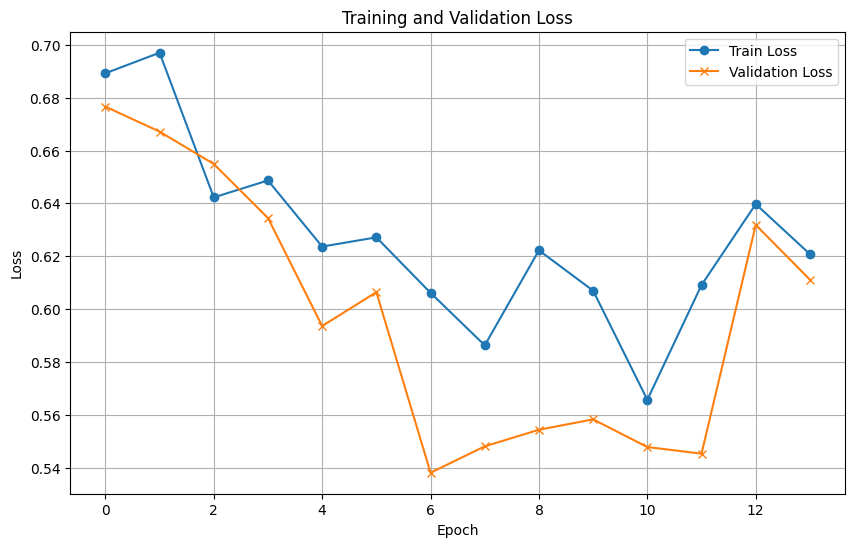

In [14]:
# Training and Validation Loss
plt.figure(figsize=(10,6))
plt.plot(train_loss_history, label='Train Loss', marker='o')
plt.plot(val_loss_history, label='Validation Loss', marker='x')
plt.title("Training and Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.legend()
plt.show()

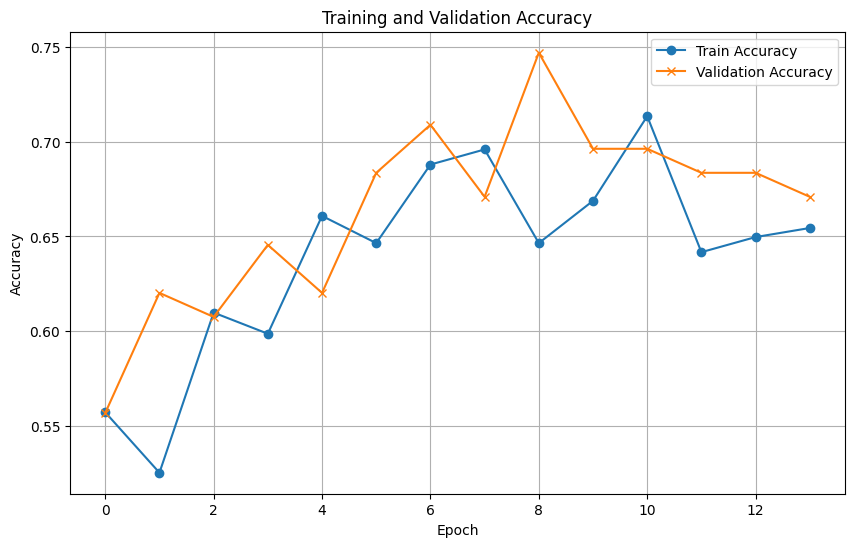

In [15]:
# Training and Validation Accuracy
plt.figure(figsize=(10,6))
plt.plot(train_acc_history, label='Train Accuracy', marker='o')
plt.plot(val_acc_history, label='Validation Accuracy', marker='x')
plt.title("Training and Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.grid(True)
plt.legend()
plt.show()

In [16]:
# Evaluate on test set
model.eval()
y_true = []
y_pred = []
with torch.no_grad():
    for fused_inputs, labels in test_ef_loader:
        fused_inputs = fused_inputs.to(device)
        labels = labels.to(device)
        outputs = model(fused_inputs).squeeze()
        preds = (outputs > 0.5).float()
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())
test_accuracy = accuracy_score(y_true, y_pred)
test_precision = precision_score(y_true, y_pred, average='binary')
test_recall = recall_score(y_true, y_pred, average='binary')
test_f1 = f1_score(y_true, y_pred, average='binary')
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test Precision: {test_precision:.4f}")
print(f"Test Recall: {test_recall:.4f}")
print(f"Test F1 Score: {test_f1:.4f}")

Test Accuracy: 0.7468
Test Precision: 0.9130
Test Recall: 0.5385
Test F1 Score: 0.6774


In [17]:
print("Classification Report:\n", classification_report(y_true, y_pred))

Classification Report:
               precision    recall  f1-score   support

         0.0       0.68      0.95      0.79        40
         1.0       0.91      0.54      0.68        39

    accuracy                           0.75        79
   macro avg       0.80      0.74      0.73        79
weighted avg       0.79      0.75      0.74        79



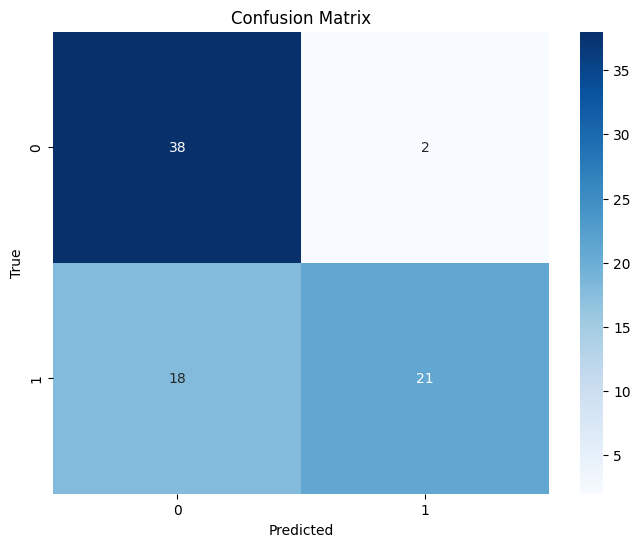

In [18]:
# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()